# Homework #6

In [1]:
## Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
 

# Question 1: Financial Sentiment Analysis

## Data Preparation

In [2]:
# Setup two lists two separate text from label
texts = []
sentiments = []

# Open the file and read line by line
with open("sometext.txt", 'r', encoding='latin1') as file:
    for line in file:
        # split the line by the @ symbol
        component = line.strip().split('@')
        # add to lists
        texts.append(component[0])
        sentiments.append(component[1])

# convert it to a pandas dataframe
df = pd.DataFrame({
    'Text': texts,
    'Sentiment': sentiments
})


In [3]:
df.head(10)

,Text,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive
5,Finnish Talentum reports its operating profit ...,positive
6,Clothing retail chain Sepp+ñl+ñ 's sales incre...,positive
7,Consolidated net sales increased 16 % to reach...,positive
8,Foundries division reports its sales increased...,positive
9,"HELSINKI ( AFX ) - Shares closed higher , led ...",positive


## Exploratory Data Analysis (EDA)

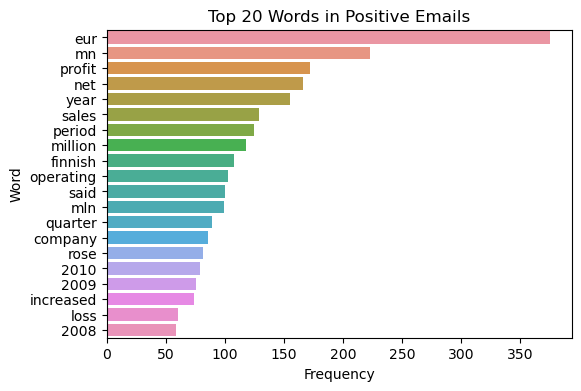

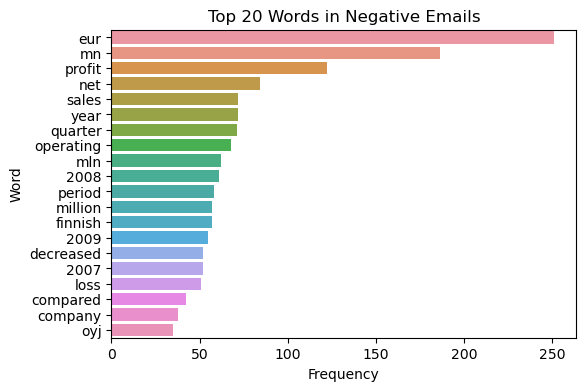

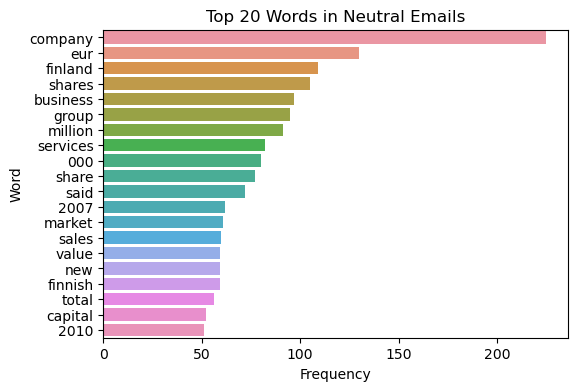

In [4]:
# Lets plot top 20 words by sentiment class

vectorizer = CountVectorizer(stop_words='english')


def plot_top_words(sentiment):
    
    # Filter DataFrame by sentiment and fit
    df_sentiment = df[df['Sentiment'] == sentiment]

    X = vectorizer.fit_transform(df_sentiment['Text'])

    # Sum words
    word_counts = X.sum(axis=0)
    words_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

    # convert to dataframe
    df_words = pd.DataFrame(words_freq, columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    top_words = df_words.head(20)
    
    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Frequency', y='Word', data=top_words)
    plt.title(f'Top 20 Words in {sentiment.capitalize()} Emails')
    plt.show()

# Show plot for each sentiment
for sentiment in ['positive', 'negative', 'neutral']:
    plot_top_words(sentiment)

In [5]:
df.groupby('Sentiment')['Sentiment'].count()

Sentiment
negative     303
neutral     1391
positive     570
Name: Sentiment, dtype: int64

<Axes: xlabel='Sentiment'>

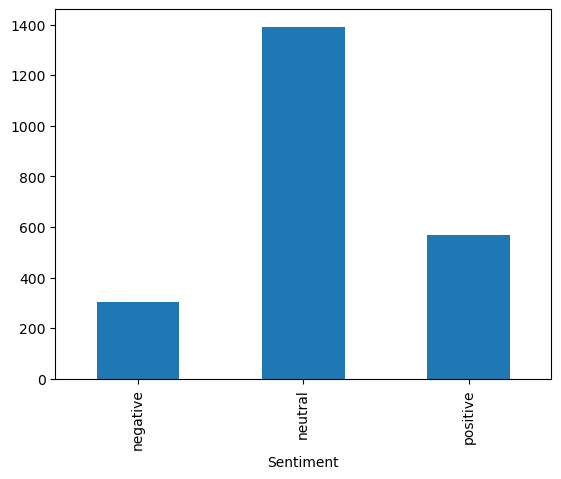

In [6]:
df.groupby('Sentiment')['Sentiment'].count().plot(kind='bar')

In [7]:
# First thing to observe is that this is an unbalanced dataset with fewer negative vs positives,
# and even less when compared with neutrals

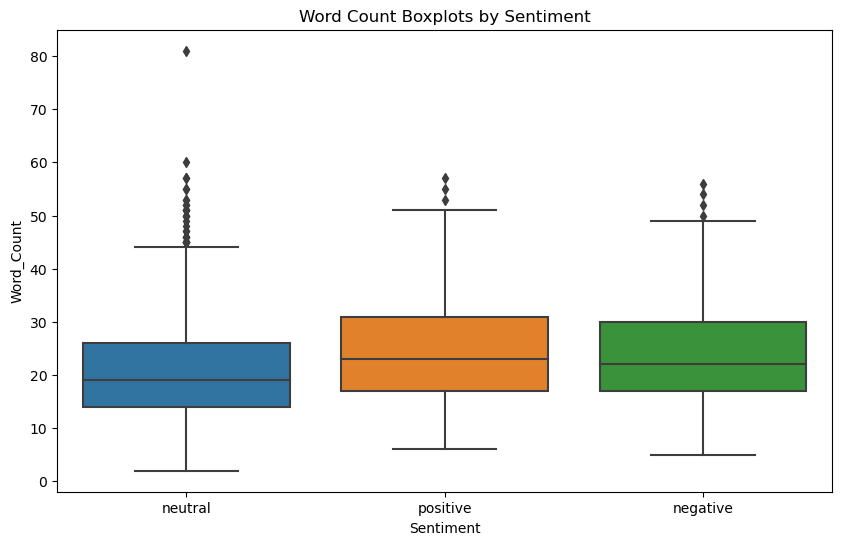

In [8]:
# Let's make a copy of the dataframe so we can operate on it without disrupting the original
df2 = df.copy()

# Calculate word count for each email
df2['Word_Count'] = df2['Text'].apply(lambda x: len(x.split()))

# boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment', y='Word_Count', data=df2)
plt.title('Word Count Boxplots by Sentiment')
plt.show()


In [9]:
df2.head()

,Text,Sentiment,Word_Count
0,"According to Gran , the company has no plans t...",neutral,25
1,"For the last quarter of 2010 , Componenta 's n...",positive,39
2,"In the third quarter of 2010 , net sales incre...",positive,29
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,24
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,22


What we see first is the neutral sentiment has a wider range (volatility) in the usage of words to describe it, but its median word count is lower than negative and positive sentiment.

Second thing is that distribution of word count for positive and negative sentiment is very similar, yet with a very slight shift upwards for positive

## Data splitting and model evaluation

### Multinomial Naive Bayes with TfidfVectorizer

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Text'], df['Sentiment'] , test_size=0.2, random_state=64)

In [11]:
# There are some adjustments I made to model to improve performance
# Max features (tokens) I increased it to 5000
# I am using ngram (combination of tokens. In this case I also used bigrams)
# Since dataset is unbalanced, I red that setting fit_prior to False, could improve performance which it did
# Alpha is a Laplace smooting factor which I changed from 1 to 0.01

model = make_pipeline(TfidfVectorizer(ngram_range=(1, 2), max_features=5000), MultinomialNB(fit_prior=False, alpha=0.01))
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('multinomialnb', MultinomialNB(alpha=0.01, fit_prior=False))])

In [12]:
y_pred = model.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

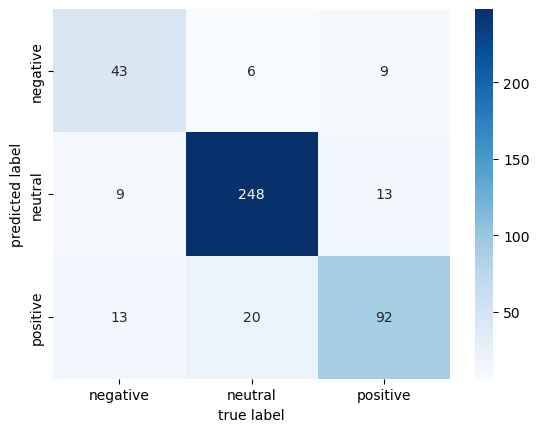

In [14]:
mat = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)

sns.heatmap(mat, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

    
plt.show()

In [15]:
# Print overall performance metrics
print(f'Accuracy: {accuracy * 100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall: {recall*100:.1f}%')
print(f'F1 Score: {f1*100:.1f}%')


Accuracy: 84.5%
Precision: 79.1%
Recall: 79.9%
F1 Score: 79.4%


### Multinomial Naive Bayes with CountVectorizer

In [16]:
#####################################
model = make_pipeline(CountVectorizer(ngram_range=(1, 2), max_features=5000), MultinomialNB(fit_prior=False, alpha=0.01))
model.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('multinomialnb', MultinomialNB(alpha=0.01, fit_prior=False))])

In [17]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

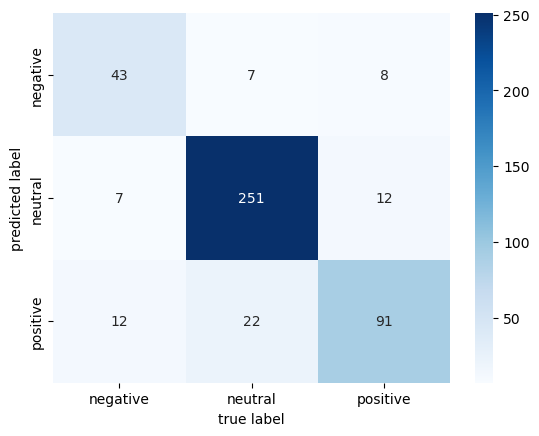

In [18]:
mat = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)

sns.heatmap(mat, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');
  
plt.show()

In [19]:
# Print overall performance metrics
print(f'Accuracy: {accuracy * 100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall: {recall*100:.1f}%')
print(f'F1 Score: {f1*100:.1f}%')


Accuracy: 85.0%
Precision: 80.3%
Recall: 80.0%
F1 Score: 80.0%


### Random Forest with CountVectorizer

In [20]:
# I tried TfidVectorizer but got better results with CountVectorizer
#TfidfVectorizer()

pipeline = Pipeline([
    ('ctvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=64))
])

# Define the parameters for grid search
param_grid = {
    'ctvec__ngram_range': [(1, 1), (1, 2)],
    'ctvec__max_features': [1000,2000,5000],
    
    'rf__n_estimators': [300, 500,1000],  
    'rf__max_depth': [None, 20], 
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fi
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ctvec', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=64))]),
             n_jobs=-1,
             param_grid={'ctvec__max_features': [1000, 2000, 5000],
                         'ctvec__ngram_range': [(1, 1), (1, 2)],
                         'rf__max_depth': [None, 20],
                         'rf__n_estimators': [300, 500, 1000]},
             verbose=2)

In [21]:
# Best parameters and best score
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

y_pred = grid_search.predict(X_test)
#print(classification_report(y_test, y_pred))


Best score: 0.855
Best parameters set:
	ctvec__max_features: 1000
	ctvec__ngram_range: (1, 1)
	rf__max_depth: None
	rf__n_estimators: 300


In [22]:
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

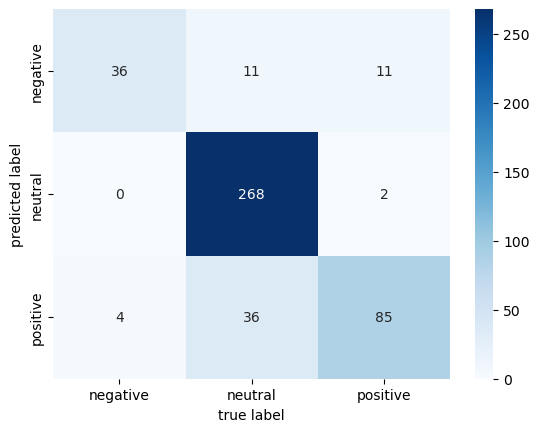

In [23]:
mat = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)

sns.heatmap(mat, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');
  
plt.show()

In [24]:
# Print overall performance metrics
print(f'Accuracy: {accuracy * 100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall: {recall*100:.1f}%')
print(f'F1 Score: {f1*100:.1f}%')


Accuracy: 85.9%
Precision: 87.3%
Recall: 76.4%
F1 Score: 80.4%


### SVM with TfidfVectorizer

In [25]:
# Pipeline for SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(probability=True))  # `probability=True` is needed for predict_proba
])

# Grid to search
parameter_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)], 
    'svm__C': [0.1, 1,5],
    'svm__kernel': ['linear','rbf']  
}

grid_search = GridSearchCV(pipeline, parameter_grid, cv=5, n_jobs=-1, verbose=2)


grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 5],
                         'svm__kernel': ['linear', 'rbf'],
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [26]:
# Print the best score and parameters
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# Evaluate on the test set
y_pred = grid_search.predict(X_test)

Best score: 0.887
Best parameters set:
	svm__C: 5
	svm__kernel: 'linear'
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)


In [27]:
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
# Print overall performance metrics
print(f'Accuracy: {accuracy * 100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall: {recall*100:.1f}%')
print(f'F1 Score: {f1*100:.1f}%')


Accuracy: 88.1%
Precision: 88.2%
Recall: 82.2%
F1 Score: 84.7%


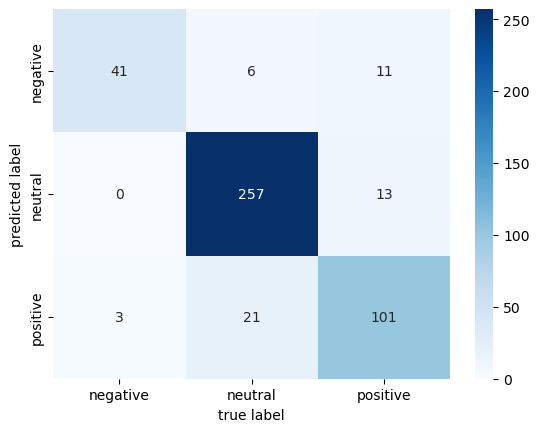

In [28]:
mat = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)

sns.heatmap(mat, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');
  
plt.show()

### SVM with an engineered featured of token count

I used the concept observed in the BoxPlots that neutrals had a slighlty lower word count than negaitve and positive, and added it as a feature.

Thus, the SVM would use the Tfidf vectotization AND the total word count per row.

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

# Custom transformer for word count. This will add a feature with the token count of each row.
class WordCountTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([len(text.split()) for text in X]).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], test_size=0.2, random_state=42)

# Pipeline
preprocess_pipeline = FeatureUnion(transformer_list=[
    ('tfidf', TfidfVectorizer()),
    ('word_count', WordCountTransformer())
])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('svm', SVC(kernel='linear'))
])

# Grid search parameters
param_grid = {
    'preprocess__tfidf__max_features': [1000,2000,5000],
    'preprocess__tfidf__max_df': [0.5, 0.75, 1.0],
    'preprocess__tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [1,5,10]
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5,n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best score: 0.887
Best parameters set:
	preprocess__tfidf__max_df: 0.75
	preprocess__tfidf__max_features: 5000
	preprocess__tfidf__ngram_range: (1, 2)
	svm__C: 5


In [30]:
# Evaluate on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

# Print overall performance metrics
print(f'Accuracy: {accuracy * 100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall: {recall*100:.1f}%')
print(f'F1 Score: {f1*100:.1f}%')


Accuracy: 90.1%
Precision: 89.0%
Recall: 84.4%
F1 Score: 86.4%


## Summary Question 1

In [54]:
# Results 

data = {
    "Classifier": ["MultinomialNB", "MultinomialNB", "RandomForest", "SVM","SVM with word count"],
    "Vectorizer": ["TfidfVectorizer", "CountVectorizer", "CountVectorizer", "TfidfVectorizer","TfidfVectorizer" ],
    "Accuracy": [84.5, 85.0, 85.9, 88.1,90.1],
    "Precision": [79.1, 80.3, 87.3, 88.2,89.0],
    "Recall": [79.9, 80.0, 76.4, 82.2,84.4],
    "F1": [79.4, 80.0, 80.4, 84.7,86.4]
}

df_results = pd.DataFrame(data)

df_results

,Classifier,Vectorizer,Accuracy,Precision,Recall,F1
0,MultinomialNB,TfidfVectorizer,84.5,79.1,79.9,79.4
1,MultinomialNB,CountVectorizer,85.0,80.3,80.0,80.0
2,RandomForest,CountVectorizer,85.9,87.3,76.4,80.4
3,SVM,TfidfVectorizer,88.1,88.2,82.2,84.7
4,SVM with word count,TfidfVectorizer,90.1,89.0,84.4,86.4


### Best results were obtained by the SVM classiffier with TfidfVectorizer AND word count feature with an Accuracy of 90.1%

# Question 2: Predicting Building Energy Efficiency

## Load and review data

In [32]:
df2 = pd.read_csv('ENB2012_data.csv')
df2.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28


In [33]:
column_names= {'X1':'Relative_Compactness',
               'X2': 'Surface_Area', 
               'X3':'Wall_Area',
               'X4':'Roof_Area', 
               'X5':'Overall_Height',
               'X6':'Orientation',
               'X7':'Glazing_Area',
               'X8':'Glazing_Area_Distribution',
               'Y1':'Heating_Load',
               'Y2':'Cooling_Load'}

# Rename the columns using the dictionary
df2.rename(columns=column_names, inplace=True)

df2.head(10)

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28
5,0.90,563.5,318.5,122.50,7.0,3.0,0.0,0.0,21.46,25.38
6,0.90,563.5,318.5,122.50,7.0,4.0,0.0,0.0,20.71,25.16
7,0.90,563.5,318.5,122.50,7.0,5.0,0.0,0.0,19.68,29.60
8,0.86,588.0,294.0,147.00,7.0,2.0,0.0,0.0,19.50,27.30
9,0.86,588.0,294.0,147.00,7.0,3.0,0.0,0.0,19.95,21.97


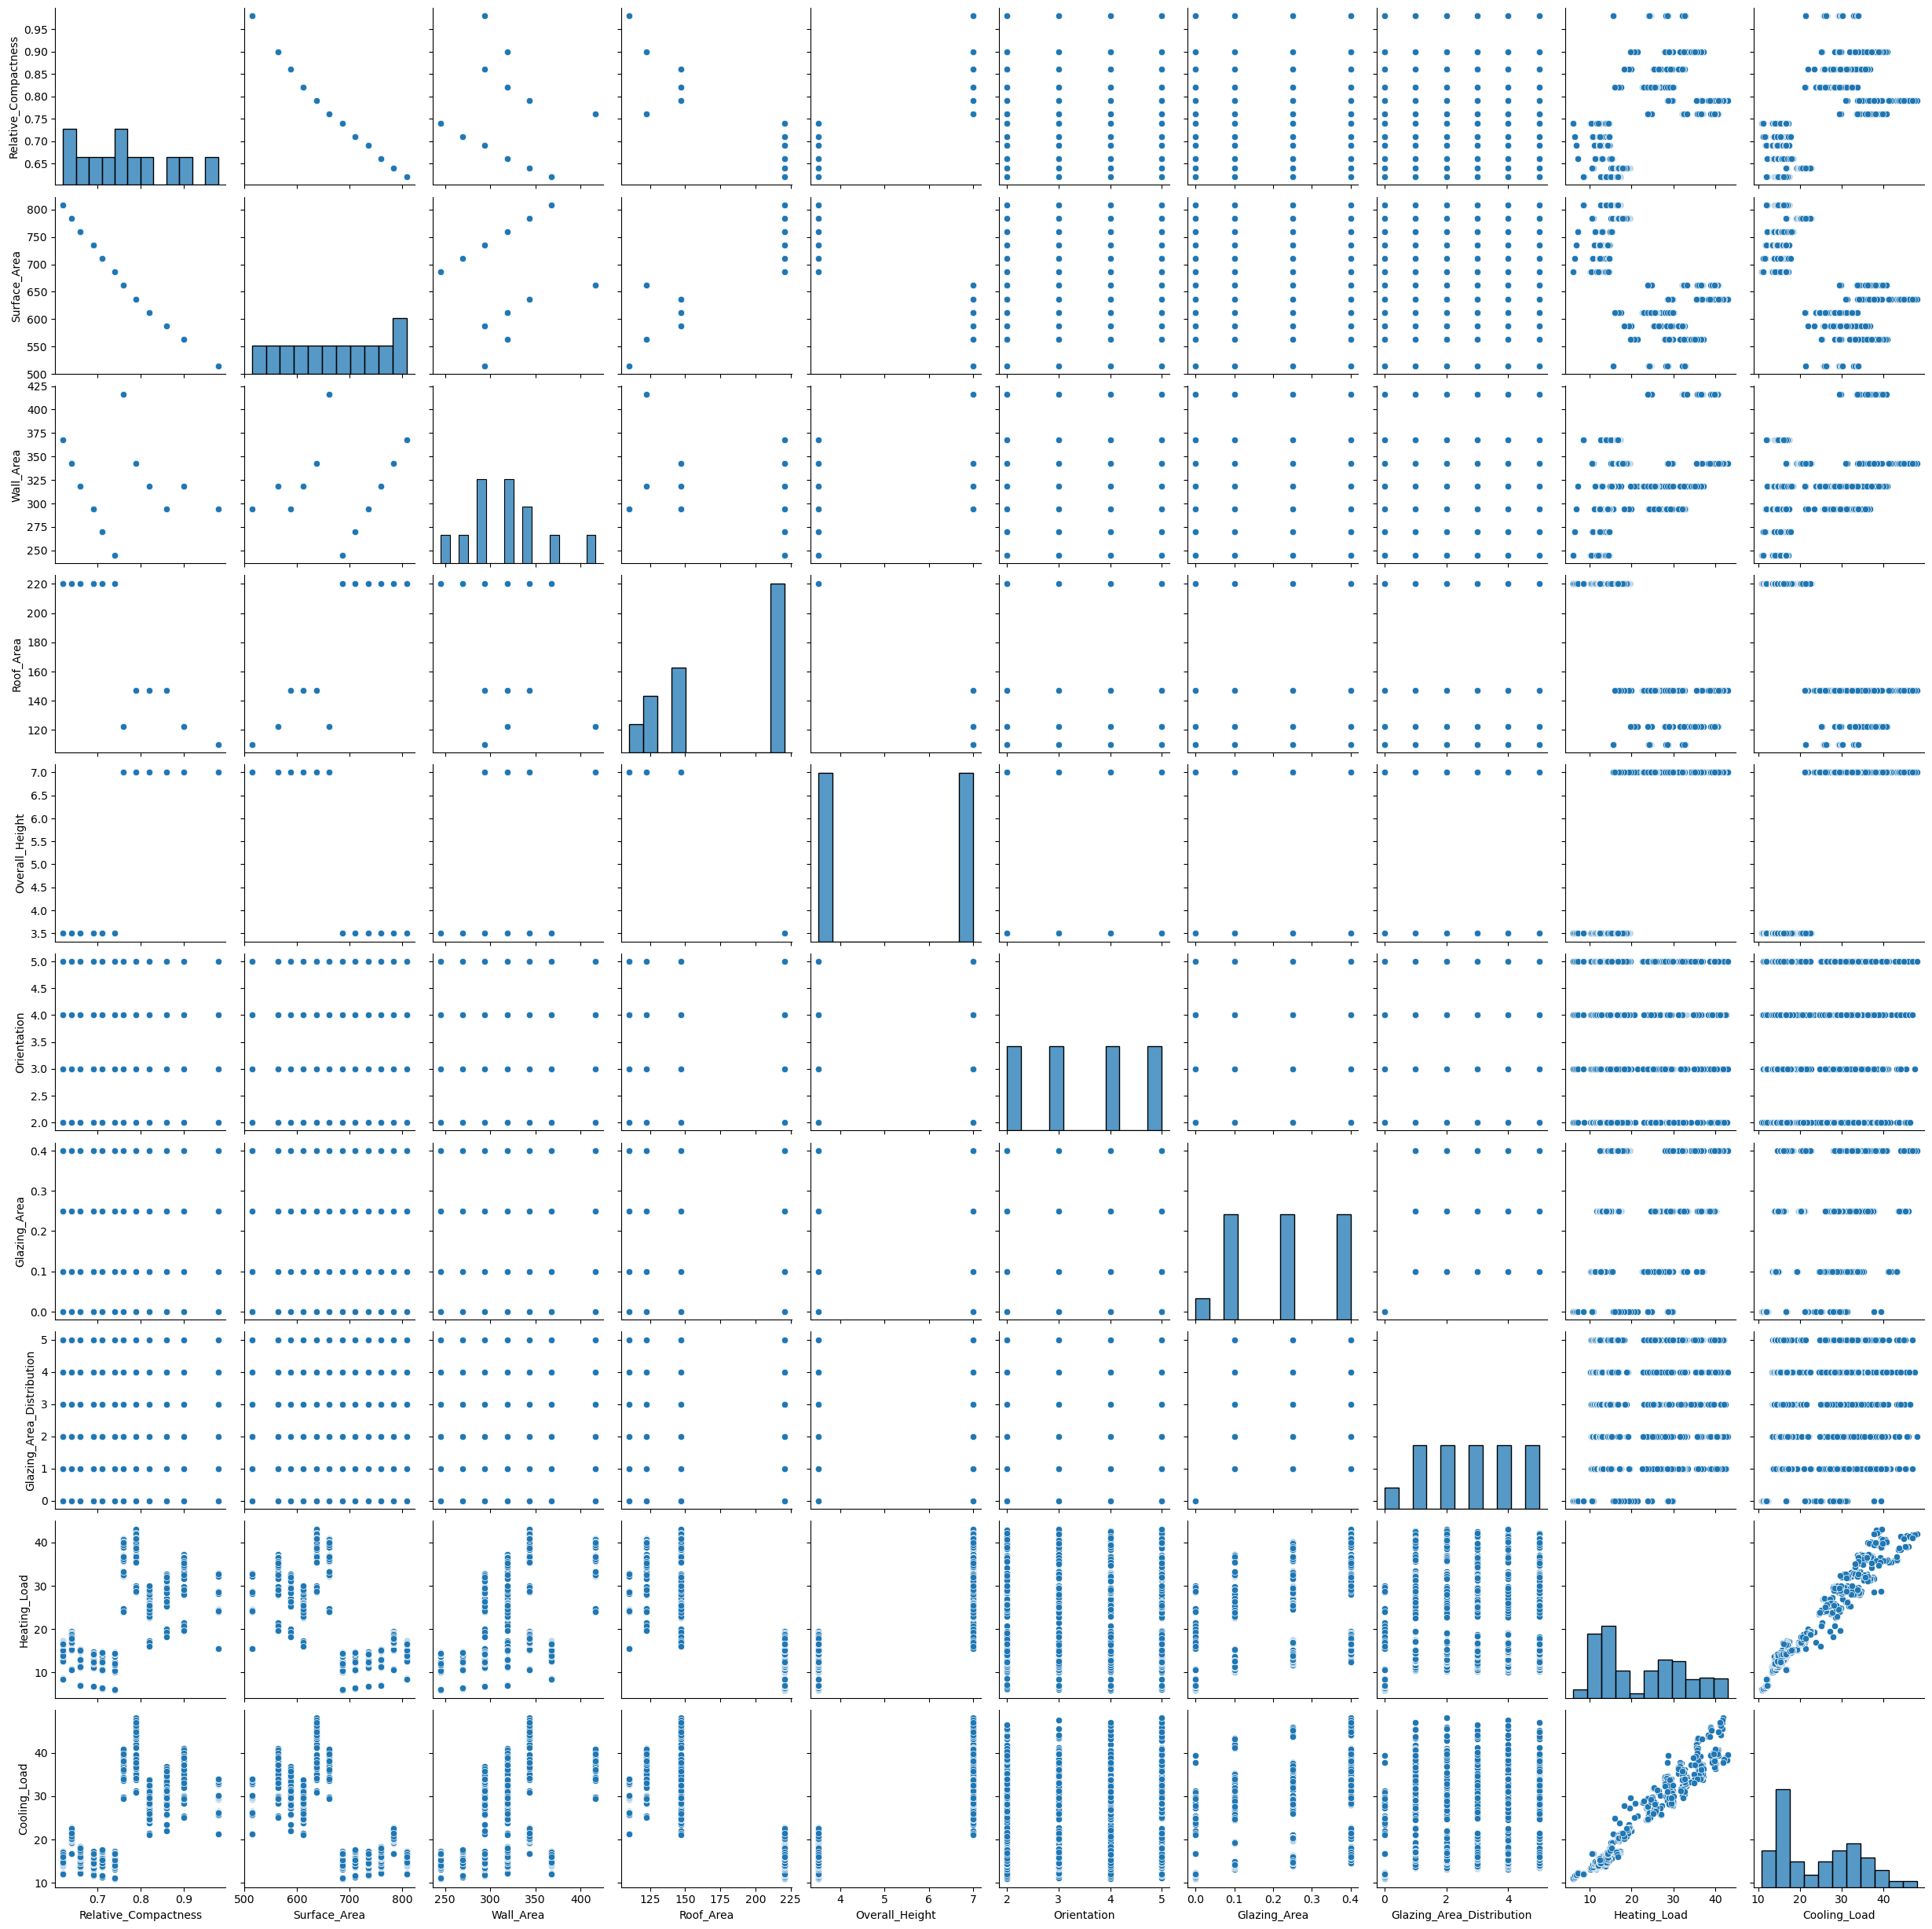

In [34]:
sns.pairplot(df2)

In [35]:
## It would seem that moste features (Besides two target column) 
#despite being numerical they seem to cluster in a few numbers for example, lets check a few

df2.groupby('Orientation')['Orientation'].count()

Orientation
2.0    192
3.0    192
4.0    192
5.0    192
Name: Orientation, dtype: int64

In [36]:
df2.groupby('Relative_Compactness')['Relative_Compactness'].count()

Relative_Compactness
0.62    64
0.64    64
0.66    64
0.69    64
0.71    64
0.74    64
0.76    64
0.79    64
0.82    64
0.86    64
0.90    64
0.98    64
Name: Relative_Compactness, dtype: int64

In [37]:
df2.groupby('Surface_Area')['Surface_Area'].count()

Surface_Area
514.5    64
563.5    64
588.0    64
612.5    64
637.0    64
661.5    64
686.0    64
710.5    64
735.0    64
759.5    64
784.0    64
808.5    64
Name: Surface_Area, dtype: int64

In [38]:
# I will treat them all categorical variable and transform them with onehotencode

In [39]:
df2.columns

Index(['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
       'Overall_Height', 'Orientation', 'Glazing_Area',
       'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load'],
      dtype='object')

In [40]:
df2.isna().sum()

Relative_Compactness         528
Surface_Area                 528
Wall_Area                    528
Roof_Area                    528
Overall_Height               528
Orientation                  528
Glazing_Area                 528
Glazing_Area_Distribution    528
Heating_Load                 528
Cooling_Load                 528
dtype: int64

In [41]:
# lets drop all row where the targets columns are NA
# Drop rows where either 'column1' or 'column2' has NA
df2 = df2.dropna(subset=['Heating_Load', 'Cooling_Load'], how='any')
df2.isna().sum()

Relative_Compactness         0
Surface_Area                 0
Wall_Area                    0
Roof_Area                    0
Overall_Height               0
Orientation                  0
Glazing_Area                 0
Glazing_Area_Distribution    0
Heating_Load                 0
Cooling_Load                 0
dtype: int64

## Fit models and select best one

In [42]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [43]:
# Initialze the estimators
reg1 = RandomForestRegressor()
reg2 = LinearRegression()
reg3 = Lasso()
reg4 = Ridge()
reg5 = ElasticNet()

#Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__n_estimators'] = [500,1000]
param1['classifier__max_depth'] = [None,20]
param1['classifier__min_samples_split'] = [5,15]
param1['classifier'] = [reg1]

param2 = {}
param2['classifier'] = [reg2]

param3 = {}
param3['classifier__alpha'] = [0.01, 0.1, 1, 5]
param3['classifier'] = [reg3]

param4 = {}
param4['classifier__alpha'] = [0.01, 0.1, 1, 5]
param4['classifier'] = [reg4]


param5 = {}
param5['classifier__alpha'] = [0.01, 0.1, 1, 5]
param5['classifier'] = [reg5]

params = [param1, param2, param3, param4, param5]


### Heating Load 

In [44]:

# Splitting the dataset into train and test sets
X = df2.drop(columns=['Heating_Load', 'Cooling_Load'])
y = df2['Heating_Load']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)


# Pre-processor for Categorical data
# We didn't really need the imputer anymore, as there are no NA, but I left in case I use code later
categorical_preprocessor = Pipeline(steps=[
    ("catimputer", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

cat_transformer = ColumnTransformer(transformers=[
    ("categorical", categorical_preprocessor, X.columns)  # Adjust this as needed
])

pipeline = Pipeline(steps=[
    ('preprocessor', cat_transformer),
     ('classifier', reg1)
], verbose=True)



In [45]:
gs = GridSearchCV(pipeline, params, cv=5, n_jobs= -1, scoring='neg_root_mean_squared_error', 
                  verbose = 2, return_train_score=True).fit(X_train, y_train)


Fitting 5 folds for each of 21 candidates, totalling 105 fits
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   4.0s


In [46]:
# Best performing model and its corresponding hyperparameters
gs.best_params_


{'classifier': RandomForestRegressor(min_samples_split=5, n_estimators=1000),
 'classifier__max_depth': None,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 1000}

In [47]:
print("Test R2 Score:",r2_score(gs.predict(X_test), y_test))
print("Test neg. RMSE Score:",mean_squared_error(gs.predict(X_test), y_test))
print("Test neg. MAE Score:",mean_absolute_error(gs.predict(X_test), y_test))


Test R2 Score: 0.9974308514904893
Test neg. RMSE Score: 0.26700261722123664
Test neg. MAE Score: 0.34611253058378183


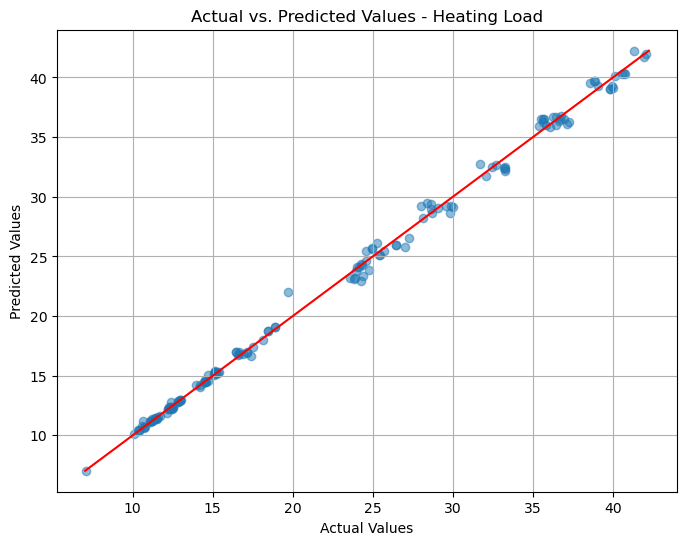

In [48]:
# Plotting actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, gs.predict(X_test), alpha=0.5)

# Plotting the 45-degree line
max_value = max(y_test.max(), gs.predict(X_test).max())
min_value = min(y_test.min(), gs.predict(X_test).min())
plt.plot([min_value, max_value], [min_value, max_value], color='red') # 45-degree line

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values - Heating Load')
plt.grid(True)
plt.show()

### Cooling_Load

In [49]:
y = df2['Cooling_Load']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)


In [50]:
gs = GridSearchCV(pipeline, params, cv=5, n_jobs= -1, scoring='neg_root_mean_squared_error', 
                  verbose = 2, return_train_score=True).fit(X_train, y_train)


Fitting 5 folds for each of 21 candidates, totalling 105 fits
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s


In [51]:
# Best performing model and its corresponding hyperparameters
gs.best_params_


{'classifier': Ridge(alpha=1), 'classifier__alpha': 1}

In [52]:
print("Test R2 Score:",r2_score(gs.predict(X_test), y_test))
print("Test neg. RMSE Score:",mean_squared_error(gs.predict(X_test), y_test))
print("Test neg. MAE Score:",mean_absolute_error(gs.predict(X_test), y_test))


Test R2 Score: 0.9701984002155336
Test neg. RMSE Score: 2.665004430989662
Test neg. MAE Score: 1.2156522063719226


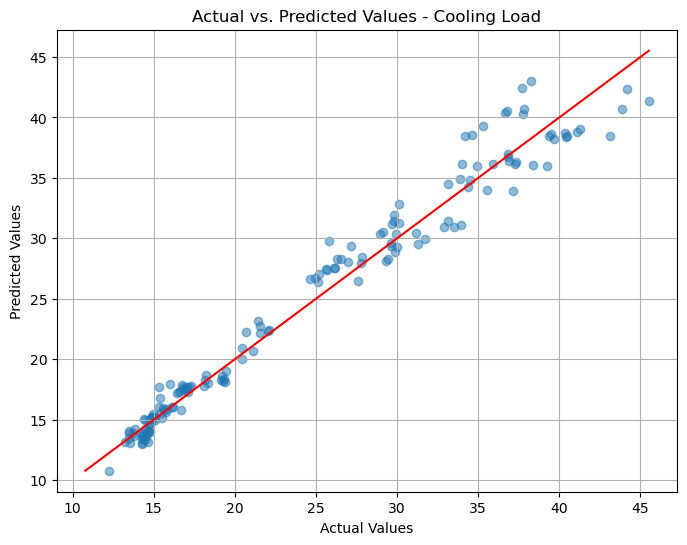

In [53]:
# Plotting actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, gs.predict(X_test), alpha=0.5)

# Plotting the 45-degree line
max_value = max(y_test.max(), gs.predict(X_test).max())
min_value = min(y_test.min(), gs.predict(X_test).min())
plt.plot([min_value, max_value], [min_value, max_value], color='red') # 45-degree line

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values - Cooling Load')
plt.grid(True)
plt.show()

## Summary Question 2


### Overall the decision to one-hot encode all columns despite being numerical, turned out to be a good choice. The R2 and other metrics ended up with very good values.
### For the Heating Load model, RANDOM FOREST was the one with best results on all 3 metrics (RMSE, MAE and R2). While for the Cooling Load model, RIDGE was the best performing in all 3 metrics.